# <center> Generalized Expectation Maximization for Gaussian Mixture Model with Bias Field Correction</center>

<ul>
    <li> <b>Coursebook Link</b>: https://www.nmr.mgh.harvard.edu/~koen/ex/mia.pdf#page=96
    <li> <b>Description</b>: mplementation of algorithm in Section 4.5
    <li> <b>Created By</b>: Rimmon Saloman Bhosale
    <li> <b>Date</b>: February 9, 2024
    <Requirements:>:
        <ul>
            <li> Python 3.9
            <li> numpy 1.26.3
            <li> scipy 1.11.3
            <li> matplotlib 3.5.3
        </ul>
</ul>

In [1]:
import copy
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
# Number of components in the Gaussian Mixture Model (GMM)
num_gmm_components = 4
# Number of basis functions
num_basis_functions = 5
# Number of epochs/iterations to update the GMM parameters
num_epochs = 101

### Utility Functions

In [3]:
def show_plots(title="Output",x_label=None,y_label=None,show_axis=True,display_plot=True):
    """
    Description:
        This function sets a few plt parameters and displays the image
    Parameters:
        title: Title of the plot
        x_label: Label for the X-axis
        y_label: Label for the Y-axis
        show_axis: Decides if the axis is to be shown
    Returns:
        None
    """
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    if not show_axis:
        plt.axis('off')
    plt.legend()
    if display_plot:
        plt.show()      

def plot_gmm(X,num_gmm_components,means,variances,gmm_prior_weights):
    """
    Description:
        This function plots the gaussian mixtures
    Parameters:
        X : Flattened image data
        num_gmm_components : Number of components (K) in the GMM
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM gmm_prior_weights : The prior weights (π_k) of the GMM
        gmm_prior_weights : The prior weights (π_k) of the GMM
    Returns:
        None
    """
    xs,ys_list,ys_mixture = mixture_of_gaussian(X,num_gmm_components,means,variances,gmm_prior_weights)
    for k,ys in enumerate(ys_list):
        plt.plot(xs,ys,label=f'Component {k + 1} ({round(means[k],2)},{round(variances[k],2)})')
    plt.plot(xs,ys_mixture, color = 'k', linestyle='--',label=f'Total Mixture')

def plot_histogram(X):
    """
    Description:
        This function plots the histogram of the flattened input image
    Parameters:
        X : The flattened input image
    Returns:
        None
    """
    hist, bins, _ = plt.hist(X, bins=256, color='blue', alpha=0.0, density=True)
    bin_centers = [np.mean((bins[i],bins[i-1])) for i in range(1,len(bins))]
    plt.plot(bin_centers,hist,label="histogram")


def calculate_intensity_range(X):
    """
    Description:
        This function calculates the minimum and maximum intensity values
    Parameters:
        X : The flattened input image
    Returns:
        minimum_intensity: Minimum intensity values
        maximum_intensity: Maximum intensity values
    """
    minimum_intensity = np.nanmin(X)
    maximum_intensity = np.nanmax(X)
    return minimum_intensity,maximum_intensity

def get_intervals(minimum_intensity,maximum_intensity,num_gmm_components):
    """
    Description:
        This function divides the pixel intensities into num_component bins
    Parameters:
        minimum_intensity: Minimum intensity values
        maximum_intensity: Maximum intensity values
        num_gmm_components: Number of components in the GMM
    Returns:
        interval_width: width of the generated intervals
        intensity_bins: range of the various intensity bins
    """
    interval_width = (maximum_intensity-minimum_intensity)//num_gmm_components
    intensity_bins = []
    start = minimum_intensity
    for k in range(num_gmm_components):
        end = start+interval_width
        intensity_bins.append([start,end])
        start = end
    return interval_width,intensity_bins

def initialize_gmm_parameters(interval_width,intensity_bins,num_gmm_components,num_basis_functions):
    """
    Description:
        This function initializes the means, variances and prior weights of the gmm
    Parameters:
        interval_width: width of the generated intervals
        intensity_bins: range of the various intensity bins
    Returns:
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM
        gmm_prior_weights : The prior weights (π_k) of the GMM
    """
    
    gmm_means = np.mean(intensity_bins,axis=1)
    gmm_variances = np.repeat(interval_width**2,num_gmm_components)
    gmm_prior_weights = np.repeat(1/num_gmm_components,num_gmm_components)
    basis_func_coefficients = np.repeat(1/num_basis_functions,num_basis_functions)
    return gmm_means,gmm_variances,gmm_prior_weights,basis_func_coefficients



### Core Functions

In [4]:

def cosine_basis_function(X, k, period=2*np.pi):
    """
    This function calculates the cosine basis function for input vector X
    Parameters:
        X : Input array
        k : Frequency of the cosine wave
        period : Period of the cosine
    Returns:
        y : The k-th cosine basis function at point(s) x.
    """
    return np.cos(2 * np.pi * k * X / period)


def sine_basis_function(X, k, period=2*np.pi):
    """
    This function calculates the sine basis function for input vector X
    Parameters:
        X : Input array
        k : Frequency of the cosine wave
        period : Period of the cosine
    Returns:
        y : The k-th sine basis function at point(s) x.
    """
    return np.sin(2 * np.pi * k * X / period)

def gaussian_pdf(X,mean,variance):
    """
    Description:
        This function calculates the likelihood of the image wrt to the given gaussian
    Parameters:
        X : Flattened image data
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM gmm_prior_weights : The prior weights (π_k) of the GMM
    Returns:
        likelihood : likelihood value for each element of X wrt the given gaussian distribution
    """
    likelihood = ((1 / np.sqrt(2 * np.pi * variance)) *  
        np.exp( -((X - mean)**2)/(2 * variance)))
    return likelihood


def mixture_of_gaussian(X,num_gmm_components,means,variances,gmm_prior_weights):
    """
    Description:
        This function calculates the mixture of multiple gaussians
    Parameters:
        X : Flattened image data
        num_gmm_components : Number of components (K) in the GMM
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM gmm_prior_weights : The prior weights (π_k) of the GMM
        gmm_prior_weights : The prior weights (π_k) of the GMM
    Returns:
        xs : Sampled x values
        ys_list : list containing likelihoods wrt different components
        ys_mixture : mixture of num_component gaussians
    """
    xs = np.linspace(
        np.nanmin(X)-np.sqrt(max(variances)),
        np.nanmax(X)+np.sqrt(max(variances)),
        len(X)
    )
    ys_list = np.zeros((num_gmm_components,len(xs)))
    ys_mixture = np.zeros_like(xs)
    for k in range(num_gmm_components):
        ys_list[k] = gaussian_pdf(xs,means[k],variances[k])*gmm_prior_weights[k]
        ys_mixture += ys_list[k]
    
    return xs,ys_list,ys_mixture

def compute_gmm_weights(X,num_gmm_components,num_basis_functions,means,variances,gmm_prior_weights):
    """
    Description:
        This function updates the weights (w^i_k) for the given image and the GMM
    Parameters:
        X : Flattened image data
        num_gmm_components : Number of components (K) in the GMM
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM gmm_prior_weights : The prior weights (π_k) of the GMM
    Returns:
        weights : Array of the size ((num_gmm_components,len(X))) representing weights w^i_k
        likelihood : Array of the size ((num_gmm_components,len(X))) representing the likelihood values of each pixel in the image belonging to component k
    """
    # Initialize the likelihood values to 0's
    likelihoods = np.zeros((num_gmm_components,len(X)))

    # Calculate the likelihood values (p(d|θ)) wrt each component in GMM
    for k in range(num_gmm_components):
        likelihoods[k] = gaussian_pdf(X,means[k],variances[k])*gmm_prior_weights[k]

    # Updating the weights (w^i_k) as described in Eq. 4.33 of the book   
    weights = likelihoods/np.nansum(likelihoods,axis=0)
    
    return weights

def update_gmm_parameters(X,weights):
    """
    Description:   
        This function performs the maximization step of the EM algorithm
    Parameters:
        X : Flattened image data
        weights : Array of the size ((num_gmm_components,len(X))) representing weights w^i_k
    Returns:
        new_means : Updated mean values of the GMM
        new_variances :Updated variance values of the GMM
        new_gmm_prior_weights : Updated prior weight values of the GMM

    """
    # Updating parameters using Eq.4.35 in the book
    new_means = np.nansum(weights*X,axis=1) / (np.nansum(weights,axis=1))
    new_gmm_prior_weights = np.nanmean(weights,axis=1) 
    new_variances = np.zeros_like(new_means)
    for k in range(len(weights)):
        new_variances[k] = np.nansum(weights[k] * np.square(X - new_means[k])) / (np.nansum(weights[k]))
    return new_means,new_variances,new_gmm_prior_weights


def calculate_log_likelihood(X, num_gmm_components, means, variances, gmm_prior_weights):
    """
    Description:
        This function computes the log likelihood values
    Parameters:
        X : Flattened image data
        num_gmm_components : Number of components (K) in the GMM
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM gmm_prior_weights : The prior weights (π_k) of the GMM
        gmm_prior_weights : The prior weights (π_k) of the GMM
    Returns:
        The log likelihood values : A scalar value representing the log likelihood
    """
    # Calculate the likelihoods
    likelihoods = np.zeros((num_gmm_components,len(X)))
    for k in range(num_gmm_components):
        likelihoods[k] = gaussian_pdf(X,means[k],variances[k])*gmm_prior_weights[k]

    # Computing the sum of likelihoods across 0th axis and ignoring the 0 values to avoid issue with log caluclation
    likelihoods_summed = np.nansum(likelihoods, axis=0)
    likelihoods_summed[likelihoods_summed==0] = np.NAN

    # Summing the likelihoods across the k components
    log_likelihood_values = np.nansum(np.log(likelihoods_summed))

    return log_likelihood_values

def calculate_lower_bound(X, num_gmm_components, means, variances, gmm_prior_weights,weights):
    """
    Description:
        This function calculates the lowerbound as defined in Eq. 4.32
    Parameters:
        X : Flattened image data
        num_gmm_components : Number of components (K) in the GMM
        means : The means (µ_k) of the GMM
        variances : The variances (σ^2_k) of the GMM gmm_prior_weights : The prior weights (π_k) of the GMM
        gmm_prior_weights : The prior weights (π_k) of the GMM
        weights: Weights array of the shape (num_gmm_components,flattened_image_size)
    Returns:
        lower_bound_value : A scalar value 
        new_means : Updated mean values
    """
    # Computing the likelihoods for the k components using the given parameters and the input X
    likelihoods = np.zeros((num_gmm_components,len(X)))
    for k in range(num_gmm_components):
        likelihoods[k] = gaussian_pdf(X,means[k],variances[k])*gmm_prior_weights[k]
    
    # Computing the lower bound
    lower_bound = np.nansum(
            np.multiply(
                weights,
                np.log(
                    likelihoods/weights
                )
            )
        )
    return lower_bound

def calculate_bias_field_artifact(X,num_basis_functions,basis_func_coefficients,basis_funct):
    basis_function_outputs = np.zeros((num_basis_functions,len(X)))
    for m in range(num_basis_functions):
        basis_function_outputs[m] = basis_func_coefficients[m]*basis_funct(X,m+10)
    return np.sum(basis_function_outputs,axis=0),  basis_function_outputs

def calculate_smoothening_weights(gmm_weights,gmm_variances):
    smoothening_weights = np.divide(gmm_weights,np.expand_dims(gmm_variances,-1))
    smoothening_vector = np.nansum(smoothening_weights,axis=0)
    smoothening_matrix = np.diag(smoothening_vector)
    return smoothening_weights,smoothening_matrix

def get_bias_corrected_image(gmm_means,smoothening_weights):
    bias_corrected_image = np.divide(
        np.sum(np.multiply(np.expand_dims(gmm_means,-1).shape,smoothening_weights.shape),0),
        np.sum(smoothening_weights,axis=0)
    )
    return bias_corrected_image



def calculate_bias_field_estimate(X,gmm_means,smoothening_weights):
    bias_corrected_image = get_bias_corrected_image(gmm_means,smoothening_weights)
    bias_field_estimate = X-bias_corrected_image
    bias_field_estimate = np.expand_dims(bias_field_estimate,-1)
    return bias_field_estimate

def update_basis_coefficients(X,phi,gmm_means,gmm_variances,gmm_weights):
    # r: bias field estimate
    # S: Smoothening matrix
    smoothening_weights, smoothening_matrix = calculate_smoothening_weights(gmm_weights,gmm_variances)

    bias_field_estimate = calculate_bias_field_estimate(X,gmm_means,smoothening_weights)

    smoothened_phi = np.matmul(
                phi.T,
                smoothening_matrix
            )
    updated_coefficients = np.matmul(
        np.linalg.inv(
            np.matmul(
                smoothened_phi,
                phi
            )
        ),
        np.matmul(
            smoothened_phi,
            bias_field_estimate
        )
    )
    return updated_coefficients.flatten()
    








    


In [5]:
# Read the input file
input_image = np.array(loadmat('segmentData.mat').get('data'),dtype=np.float64)

# Flatten the input image into 1D array
flattened_image = input_image.reshape(np.prod(input_image.shape))
# flattened_image = np.nan_to_num(flattened_image)
# Replace 0's in image by NaN
# flattened_image[flattened_image == 0] = np.NAN


In [6]:
minimum_intensity, maximum_intensity = calculate_intensity_range(flattened_image)
interval_width,intensity_bins = get_intervals(minimum_intensity,maximum_intensity,num_gmm_components)
print("Interval width : ",interval_width)
print("Intervals : ",intensity_bins)

Interval width :  224.0
Intervals :  [[0.0, 224.0], [224.0, 448.0], [448.0, 672.0], [672.0, 896.0]]


In [7]:
gmm_means,gmm_variances,gmm_prior_weights,basis_func_coefficients = initialize_gmm_parameters(interval_width,intensity_bins,num_gmm_components,num_basis_functions)

print("Initial Mean Values : ",gmm_means)
print("Initial Variance Values : ",gmm_variances)
print("Initial Prior Weight Values : ",gmm_prior_weights)
print("Initial Basis Function Coefficients Values : ",basis_func_coefficients)

Initial Mean Values :  [112. 336. 560. 784.]
Initial Variance Values :  [50176. 50176. 50176. 50176.]
Initial Prior Weight Values :  [0.25 0.25 0.25 0.25]
Initial Basis Function Coefficients Values :  [0.2 0.2 0.2 0.2 0.2]


0
New Means:  [ 90.9611482  155.87098889 276.05565926 470.57673349]
New Variances:  [10214.30488511 19674.84851841 35444.35644734 47854.73999677]
New Priors:  [0.52588014 0.33042713 0.11424217 0.02945056]
New Coefficients:  [-1.23570803e+07 -1.25398275e+07 -1.71106730e+07  1.53231439e+08
 -1.51331060e+07]
1


/tmp/ipykernel_2947741/64916236.py:91: RuntimeWarning: invalid value encountered in divide
  weights = likelihoods/np.nansum(likelihoods,axis=0)
/tmp/ipykernel_2947741/64916236.py:182: RuntimeWarning: divide by zero encountered in divide
  smoothening_weights = np.divide(gmm_weights,np.expand_dims(gmm_variances,-1))


New Means:  [641. 641. 641. 641.]
New Variances:  [0.00000000e+00 0.00000000e+00 1.29246971e-26 0.00000000e+00]
New Priors:  [4.32801912e-160 1.03364942e-063 1.53884245e-017 1.00000000e+000]
New Coefficients:  [nan nan nan nan nan]
2


/tmp/ipykernel_2947741/64916236.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  likelihood = ((1 / np.sqrt(2 * np.pi * variance)) *
/tmp/ipykernel_2947741/64916236.py:38: RuntimeWarning: divide by zero encountered in divide
  np.exp( -((X - mean)**2)/(2 * variance)))
/tmp/ipykernel_2947741/64916236.py:37: RuntimeWarning: invalid value encountered in multiply
  likelihood = ((1 / np.sqrt(2 * np.pi * variance)) *
/tmp/ipykernel_2947741/64916236.py:109: RuntimeWarning: invalid value encountered in divide
  new_means = np.nansum(weights*X,axis=1) / (np.nansum(weights,axis=1))
/tmp/ipykernel_2947741/64916236.py:110: RuntimeWarning: Mean of empty slice
  new_gmm_prior_weights = np.nanmean(weights,axis=1)
/tmp/ipykernel_2947741/64916236.py:113: RuntimeWarning: invalid value encountered in scalar divide
  new_variances[k] = np.nansum(weights[k] * np.square(X - new_means[k])) / (np.nansum(weights[k]))


New Means:  [nan nan nan nan]
New Variances:  [nan nan nan nan]
New Priors:  [nan nan nan nan]
New Coefficients:  [nan nan nan nan nan]
3
New Means:  [nan nan nan nan]
New Variances:  [nan nan nan nan]
New Priors:  [nan nan nan nan]
New Coefficients:  [nan nan nan nan nan]
4
New Means:  [nan nan nan nan]
New Variances:  [nan nan nan nan]
New Priors:  [nan nan nan nan]
New Coefficients:  [nan nan nan nan nan]
5
New Means:  [nan nan nan nan]
New Variances:  [nan nan nan nan]
New Priors:  [nan nan nan nan]
New Coefficients:  [nan nan nan nan nan]
6
New Means:  [nan nan nan nan]
New Variances:  [nan nan nan nan]
New Priors:  [nan nan nan nan]
New Coefficients:  [nan nan nan nan nan]
7
New Means:  [nan nan nan nan]
New Variances:  [nan nan nan nan]
New Priors:  [nan nan nan nan]
New Coefficients:  [nan nan nan nan nan]
8
New Means:  [nan nan nan nan]
New Variances:  [nan nan nan nan]
New Priors:  [nan nan nan nan]
New Coefficients:  [nan nan nan nan nan]
9
New Means:  [nan nan nan nan]
New 

/home/v-labsai-rimmon-bhosale/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6613: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/v-labsai-rimmon-bhosale/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6614: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

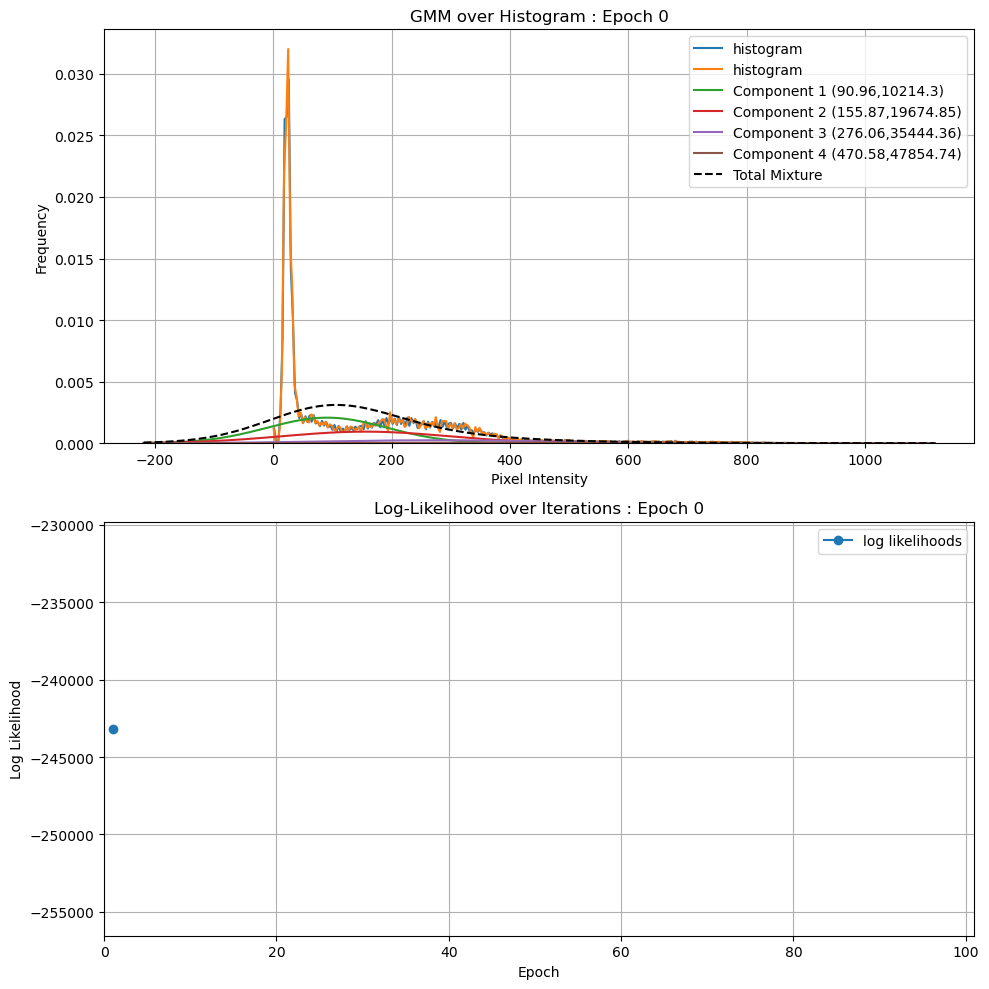

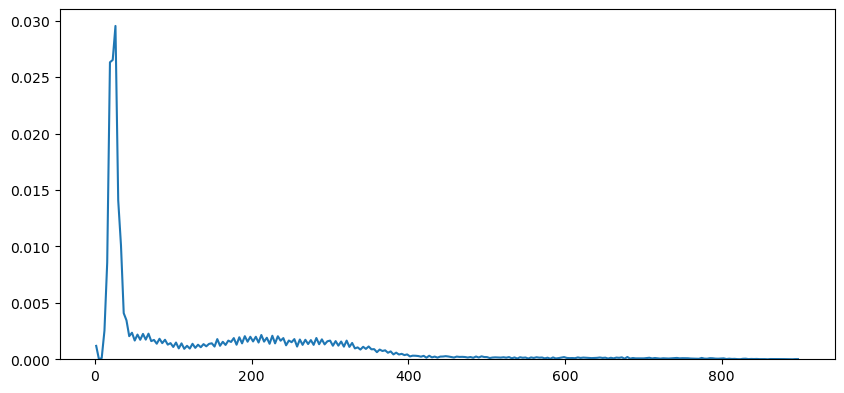

In [8]:
basis_function = cosine_basis_function

gmm_means,gmm_variances,gmm_prior_weights,basis_func_coefficients = initialize_gmm_parameters(interval_width,intensity_bins,num_gmm_components,num_basis_functions)

log_likelihoods_over_iterations = []

for epoch in range(num_epochs):
    print(epoch)
    bias_field_artifact, basis_function_outputs = calculate_bias_field_artifact(flattened_image,num_basis_functions,basis_func_coefficients,basis_function)

    bias_field_corrected_img = flattened_image-bias_field_artifact
    # print("corrected img ",bias_field_corrected_img.shape)

    gmm_weights = compute_gmm_weights(bias_field_corrected_img,num_gmm_components,num_basis_functions,gmm_means,gmm_variances,gmm_prior_weights)
    # print("gmm weights ",gmm_weights.shape)

    gmm_means,gmm_variances,gmm_prior_weights =  update_gmm_parameters(flattened_image,gmm_weights)
    # print("mean, var, prior ",gmm_means,gmm_variances,gmm_prior_weights)

    phi = basis_function_outputs.T
    basis_func_coefficients = update_basis_coefficients(flattened_image,phi,gmm_means,gmm_variances,gmm_weights)
    # print("basis function coefficients",basis_func_coefficients)

    print("New Means: ",gmm_means)
    print("New Variances: ",gmm_variances)
    print("New Priors: ",gmm_prior_weights)
    print("New Coefficients: ",basis_func_coefficients)
    
    log_likelihoods_over_iterations.append(calculate_log_likelihood(bias_field_corrected_img, num_gmm_components, gmm_means, gmm_variances, gmm_prior_weights))
    if epoch%10==0:
        plt.figure(figsize=(10,10))
        plt.subplot(2,1,1);
        plot_histogram(flattened_image)
        plot_histogram(bias_field_corrected_img)
        plot_gmm(flattened_image,num_gmm_components,gmm_means,gmm_variances,gmm_prior_weights)
        show_plots(title=f"GMM over Histogram : Epoch {epoch}",x_label="Pixel Intensity",y_label="Frequency",display_plot=False)
    
        plt.subplot(2,1,2);
        plt.plot([x+1 for x in range(epoch+1)], log_likelihoods_over_iterations, marker='o',label="log likelihoods")
        plt.xlim(0, num_epochs)
        # plt.ylim(-80000, -74000)
        show_plots(title=f'Log-Likelihood over Iterations : Epoch {epoch}', x_label="Epoch",y_label="Log Likelihood",display_plot=False)
        plt.tight_layout()
        
